# Optimized gauge transformation

## The goal of this notebook is to perform the gauge transformation in an optimized way inside the temporal loop so we can later move it to the GPU

### Set parametres and eviroment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
N = 128   
tau_sim = 1     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

In [2]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="3"

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.gauge_transformation as gt
# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### We define the simulation routine

In [3]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    # output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Plus gauge link
    uplus_LC = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, N, Dg)))
    v_LC = su.GROUP_TYPE([[[su.unit() for z in range (N)] for y in range(N)] for xplus in range (maxt//DTS)])

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            
            # Initialize the gauge transformation operator
            if t == 1:
                u_aux = s.u0.copy()
                ux_init = u_aux[:,0,:].reshape(N,N,Dg)
                ae_init = s.aeta0.copy().reshape(N, N, Dg)
                
                for xplus in range(maxt//DTS):
                    for y in range(N):
                        for z in range(N):
                            v_LC[xplus, y, z] = su.dagger(su.mul(su.mul_s(ae_init[2*xplus,y], (z-N//2)*a), ux_init[2*xplus,y]))
            

            # Copy gauge links and gauge fields from the memory of the GPU
            if t%DTS == 0 and t!=0:
                u1 = s.u1.copy()
                u0 = s.u0.copy()
                
                ux_act = u1[:,0,:].reshape(N,N,Dg)
                ux_prev = u0[:,0,:].reshape(N,N,Dg)
                
                ae_act = s.aeta1.copy().reshape(N, N, Dg)
                ae_prev = s.aeta0.copy().reshape(N, N, Dg)
                
                # We construct the u_+ links over the x^+ axis in a (y,z) transverse lattice
                # uplus_temp = su.GROUP_TYPE(np.zeros((N,N,Dg)))
                
                # for y in range(N):
                #     for z in range(N):
                #         # uplus_temp[y, z] = su.mul(su.mexp(su.mul_s(ae_prev[t//DTS, y], 1j*g*a*(z-N//2))), ux_prev[t//DTS, y])
                #         uplus_temp[y, z] = gt.get_plus_links(ux_prev[t//DTS,y], ae_prev[t//DTS,y], z, N)
                #         # uplus_temp[y, z] = gt.get_plus_links(ux_prev[t//DTS,y], ae_prev[t//DTS,y], z, N)
                
                
                # We construct the gauge operator and transform the field
                for xplus in range(maxt//DTS):
                    for y in range(N):
                        for z  in range(N):
                            
                            if xplus > (t//DTS): # We construct the gauge operator
                                v_prev = v_LC[xplus, y, z]
                                # umin = su.mul(su.mexp(su.mul_s(ae_act[2*xplus-t//DTS, y], 1j*g*a*(z-N//2))), su.dagger(ux_act[2*xplus-t//DTS, y]))
                                # v_LC[xplus, y, z] = su.mul(umin, v_prev)
                                # v_LC[xplus, y, z] = gt.gauge_transformation_operator(ux_act[2*xplus-t//DTS,y], ae_act[2*xplus-t//DTS,y], v_prev, z, N)
                                v_LC[xplus, y, z] = gt.gauge_transformation_operator(ux_act[2*xplus-t//DTS,y], ae_act[2*xplus-t//DTS,y], v_prev, z, N, a, t)
                                
                            elif xplus == (t//DTS):
                                # uplus_LC[xplus-1, y, z] = su.mul(su.mul(su.dagger(v_LC[xplus, y, z]), uplus_temp[y,z]), v_LC[xplus-1, y, z])
                                uplus_LC[xplus-1, y, z] = gt.act_on_links(ux_prev[t//DTS,y], ae_prev[t//DTS,y], v_LC[xplus, y, z], v_LC[xplus-1, y, z], z, N, a, t)
                                
                
            
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return uplus_LC #ux2 #, uy, aeta

In [4]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
uplus_LC = simulate()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Kernel xi: 0 d:  0 did not reach goal. check:  0.0003971826844128448
Kernel xi: 0 d:  1 did not reach goal. check:  0.0007075096728432758
Kernel xi: 1 d:  0 did not reach goal. check:  0.0003571703591289482
Kernel xi: 1 d:  1 did not reach goal. check:  0.00039656025804553265
Kernel xi: 2 d:  0 did not reach goal. check:  0.00034795361168538373
Kernel xi: 2 d:  1 did not reach goal. check:  0.0006765654938896186
Kernel xi: 3 d:  0 did not reach goal. check:  0.0003673751971867122
Kernel xi: 3 d:  1 did not reach goal. check:  0.0009135352699250948
Kernel xi: 4 d:  0 did not reach goal. check:  0.00043433109314377295
Kernel xi: 4 d:  1 did not reach goal. check:  0.000949033521052119
Kernel xi: 5 d:  0 did not reach goal. check:  0.0005352355150583414
Kernel xi: 5 d:  1 did not reach goal. check:  0.0009183558613451115
Kernel xi: 6 d:  0 did not reach goal. check:  0.0006359834633192013
Kernel xi: 6 d:  1 did not reach goal. check:  0.0008742523056294422
Kernel xi: 7 d:  0 did not reach

  2%|▏         | 9/512 [00:08<07:01,  1.19it/s]

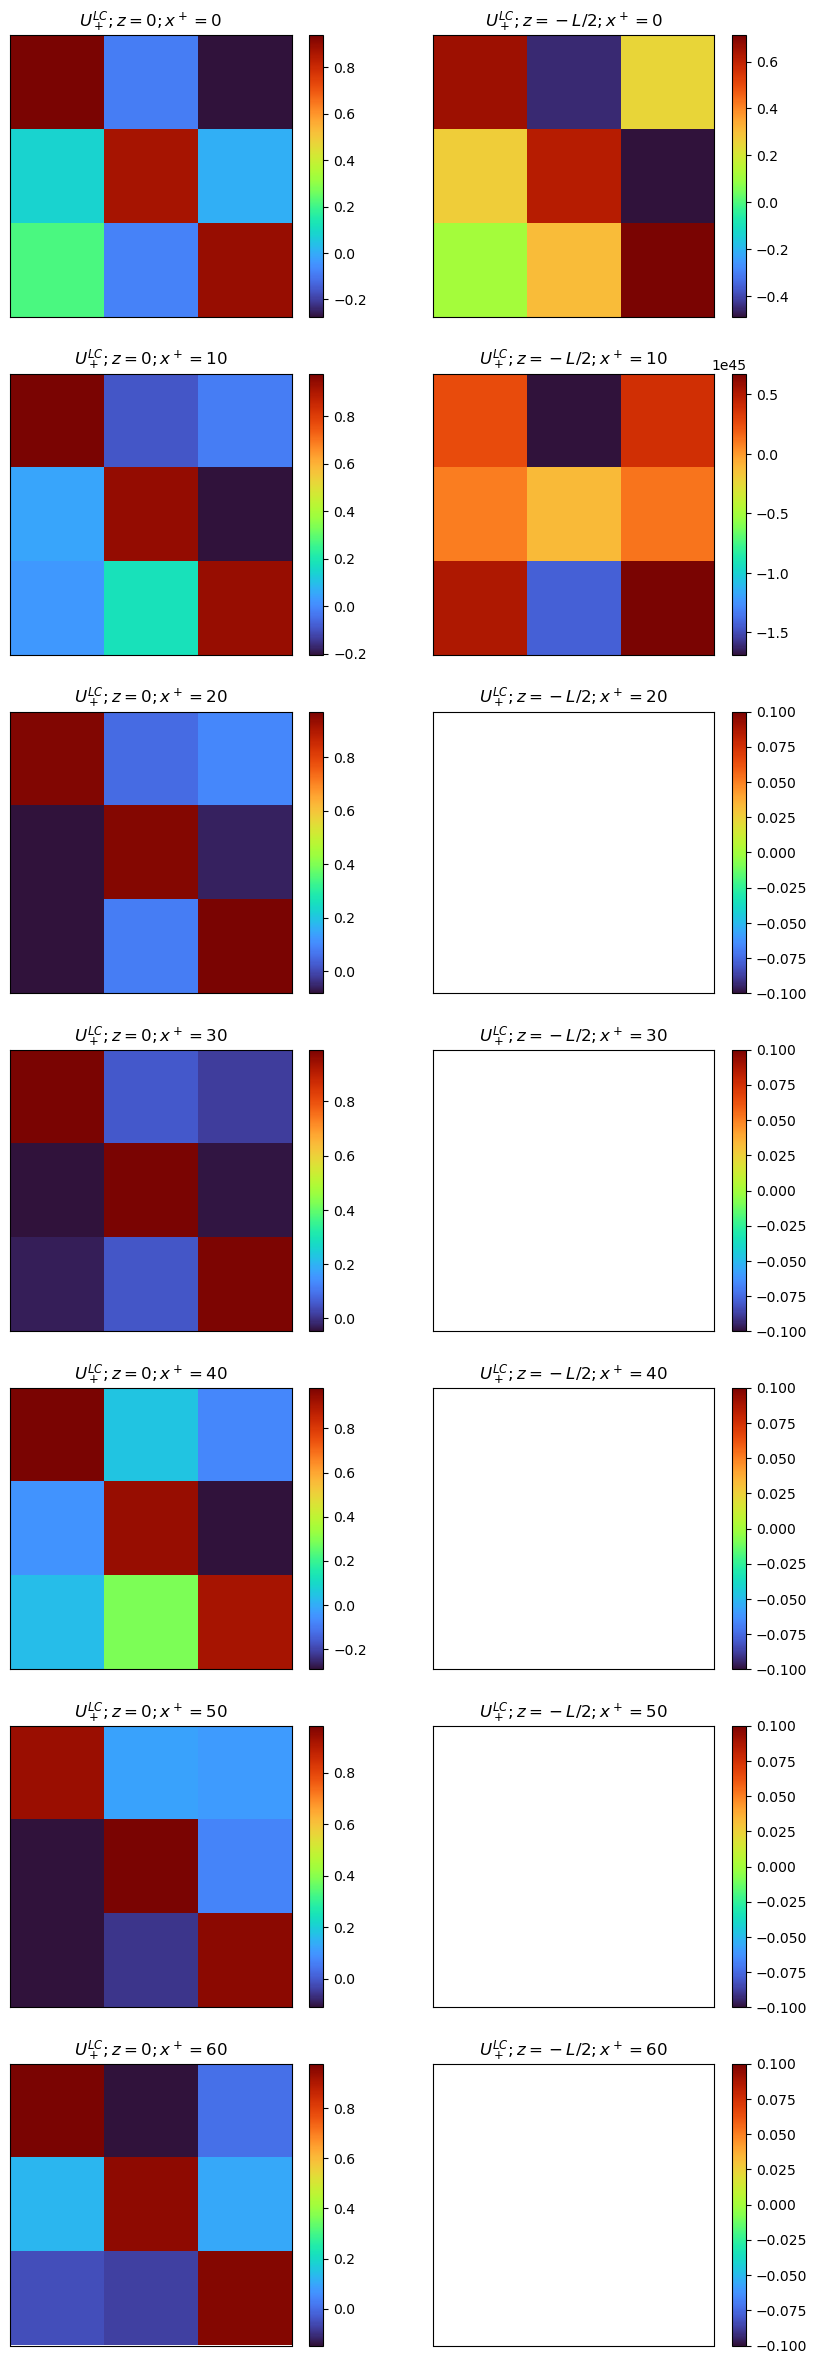

In [ ]:
import matplotlib.pyplot as plt 

t_steps = int(tau_sim*N / L)
y = N//2

uplus_LC_plot = uplus_LC.reshape(t_steps-1, N, N, 3, 3)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_LC_plot[tau, y, N//2, :, :].real, cmap='turbo') 
    axs[t,0].set_title(r'$U_+^{LC}; z =0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uplus_LC_plot[tau, y, N//4, :, :].real, cmap='turbo')
    axs[t,1].set_title(r'$U_+^{LC}; z = -L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

In [ ]:
print(uplus_LC_plot[30, N//2, 0, :, :])

[[nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj]]


- - -
Write the outputs to files. First, the numerical Glasma parameters in `glasma_parameters.txt`.

In [ ]:
# Save relevant parameters to text file
param_names = ["L [fm]", "N", "a [fm]", "tau_sim [fm/c]", "tau_steps"]
# The last time step in x^+ in skipped, so only N/2-1 time steps
# The lattice discretization in z coincides with the one in y
param_values = [L, N, L/N, tau_sim, int(N/2)-1]

# output_file = open("glasma_parameters_v2.txt", "a")
output_file = open("glasma_parameters.txt", "a")
for p in range(len(param_names)):
    output_file.write(param_names[p] + " " + str(param_values[p]) + "\n")
output_file.close()

In [ ]:
# Save relevant parameters to text file
param_names = ["L_perp [GeV^-1]", "N_perp", "time_tot [GeV^-1]", "time_step"]
# The last time step in x^+ in skipped, so only N/2-1 time steps
# The lattice discretization in z coincides with the one in y
param_values = [L/2/hbarc, round(N/2), tau_sim*np.sqrt(2)/hbarc, int(N/2)-1]

# output_file = open("glasma_parameters_v2.txt", "a")
output_file = open("glasma_parameters_qjetlfh_input.txt", "a")
for p in range(len(param_names)):
    output_file.write(param_names[p] + " " + str(param_values[p]) + "\n")
output_file.close()

Second, the transformed gauge link $U_+ (x^+, y, z)$ as a `numpy` array in `uplus_glasma.npy`.

In [ ]:
np.save('uplus_glasma_v2.npy', uplus_LC)

In [ ]:
# I use this values to test that reading the numpy array in C++ is correct
uplus_LC[10, 12, 10, :]

array([ 0.4737372 -0.48802875j,  0.22288397-0.67103547j,
        0.12722559-0.14575739j, -0.43649399-0.46640112j,
        0.54989264+0.33440651j,  0.23809732-0.3479128j ,
       -0.29909853+0.19970735j, -0.06651603-0.28530407j,
        0.83396221+0.29889591j])

- - -
Read the input file `uplus_glasma.npy` sent to Meijian.

In [ ]:
uplus_file = np.load('uplus_glasma.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'uplus_glasma.npy'

Output a time slice, let's choose $x^+_\mathrm{lattice}=10$, the (y,z) dependence, in a `*.txt` file, for Meijian.

In [ ]:
# Output each color components in a different file, as a yz array

folder_path = "uplus_glasma_xplus_10_color/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for c in range(Dg):
    output_file = open(folder_path + "c_" + str(c) + ".txt", "a")
    for y in range(N):
        for z in range(N):
            output_file.write(str(uplus_file[10, y, z, c]) + " ")
            if z==(N-1):
                output_file.write(str(uplus_file[10, y, z, c]) + "\n")
output_file.close()

In [ ]:
folder_path = "uplus_glasma_xplus_10_coord/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Output all color components for each yz pair in a different file
for y in range(N):
    for z in range(N):
        output_file = open(folder_path + "y_" + str(y) + "_z_" + str(z) + ".txt", "a")
        for c in range(Dg):
            output_file.write(str(uplus_file[10, y, z, c]) + "\n")
output_file.close()